# Epymorph dev log: May 31, 2023

Author: Alexander Nez

as of git hash:

### Social Determinate of Health (sdh)

### sdh toml params
theta = 0.1 

move_control = 0.9

infection_duration = 4.0

immunity_duration = 90.0

infection_seed_loc = 0

infection_seed_size = 100

hospitalization_duration = 14.0

alpha = [0.1, 0.3, 0.2]



# sdh with pei movement

### plots sdh model by prevalence
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params "./scratch/params/sdh_params.toml" --start_date "2015-01-01" --duration "150d" --chart "p0" --out ./scratch/output_files/sdh.csv 
### creates sirh_sdh
python -m epymorph run --ipm sdh --mm icecube --geo maricopa_cbg_2019 --params ./scratch/params/sdh_params.toml --start_date 2015-01-01 --duration 150d --out ./scratch/output_files/sdh.csv 

In [1]:
from epymorph.run import run
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.simulation import Simulation
from epymorph.world import Population 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import squareform
from numpy.typing import DTypeLike, NDArray
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import pdist
from IPython.core.display import SVG
from matplotlib.pyplot import xlabel
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
from numpy import size
import seaborn as sns
import pandas as pd
import numpy as np
import pydot
import os

with np.load(f"./epymorph/data/geo/maricopa_cbg_2019_geo.npz") as npz_data:
        data = dict(npz_data)

%matplotlib inline

dir = os.path.expanduser('~/Desktop/Github/Epymorph/scratch')



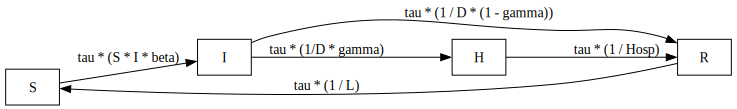

In [7]:
diagram_dot = """digraph {
    rankdir=LR;
    node [shape=box];
    S -> I [label="tau * (S * I * beta)"];
    I -> R [label="tau * (1 / D * (1 - gamma)) "];
    I -> H [label="tau * (1/D * gamma)"];
    H -> R [label="tau * (1 / Hosp)"];
    R -> S [label="tau * (1 / L)"]
}"""
diagram = pydot.graph_from_dot_data(diagram_dot)[0]  # type: ignore
SVG(data = diagram.create_svg())

Loading requirements:
[✓] IPM (sdh)
[✓] MM (centroids)
[✓] Geo (maricopa_cbg_2019)
[✓] Parameters (file:/Users/alexandernez/Desktop/Github/Epymorph/scratch/params/sdh_params.toml)

Running simulation:
• 2015-01-01 to 2015-05-31 (150 days)
• 2505 geo nodes
|####################| 100% 
Runtime: 1120.993s
Displaying chart: p0


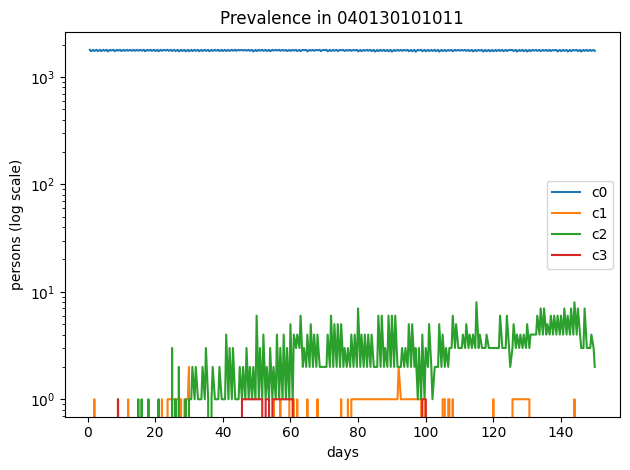

Writing output to file: /Users/alexandernez/Desktop/Github/Epymorph/scratch/output_files/sirh.csv
Done


In [120]:
exit_code = run(
    ipm_name = 'sdh',
    mm_name = 'centroids',
    geo_name = 'maricopa_cbg_2019',
    start_date_str = '2015-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params/sdh_params.toml",
    out_path = f"{dir}/output_files/sirh.csv",
    chart = 'p0',
    profiling=False
)

# Creates the Maricopa County dataframe

In [17]:
geo = 'https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/04_ARIZONA/04013/tl_2020_04013_bg10.zip'
maricopa = gpd.read_file(geo)

In [19]:
# lon , lat
n = len(data['labels'])
distance = np.zeros((n,n))
def haversine(centroid_1_lon: float,
              centroid_1_lat: float,
              centroid_2_lon: float, 
              centroid_2_lat: float) -> np.double:

    R = 3959.87433 

    dLat = np.radians(centroid_1_lat - centroid_2_lat)
    dLon = np.radians(centroid_1_lon - centroid_2_lon)
    lat1 = np.radians(centroid_1_lat)
    lat2 = np.radians(centroid_2_lat)

    a = np.sin(dLat/2)**2 + np.cos(lat1)* np.cos(lat2)* np.sin(dLon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    
    return R * c
        
for i in range(n):
       for j in range(n):
              if i != j:
                distance[i, j] = haversine(data['centroid'][i][0],
                                           data['centroid'][i][1],
                                           data['centroid'][j][0], 
                                           data['centroid'][j][1])

a = np.asarray(distance)
np.savetxt("dist.csv", a, delimiter=",")


In [4]:
phi_40 = np.zeros((n,n))
phi_20 = np.zeros((n,n))
phi_10 = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        phi_40[i,j] = 1 / (np.exp(a[i,j] * (1/40)))

for i in range(n):
    for j in range(n):
        phi_20[i,j] = 1 / (np.exp(a[i,j] * (1/20)))

for i in range(n):
    for j in range(n):
        phi_10[i,j] = 1 / (np.exp(a[i,j] * (1/10)))
 
phi_40 = pd.DataFrame(phi_40)
phi_20 = pd.DataFrame(phi_20)  
phi_10 = pd.DataFrame(phi_10)  
dist = pd.DataFrame(a)


In [5]:
phi_40.to_csv(dir + '/utility/phi_40.csv')
phi_20.to_csv(dir + '/utility/phi_20.csv')
phi_10.to_csv(dir + '/utility/phi_10.csv')
dist.to_csv(dir + '/utility/dist.csv')

In [6]:
cgb_40 = phi_40.iloc[:,0]
cgb_20 = phi_20.iloc[:,0]
cgb_10 = phi_10.iloc[:,0]
cgb_d = dist.iloc[:,0]
data_cgb = [cgb_d, cgb_40,cgb_20, cgb_10 ]
cgb = pd.concat(data_cgb, axis =1)
cgb.columns = ["distance", "phi 40", "phi 20", "phi 10"]
cgb = cgb.sort_values(by= 'distance')

# Creates the Social Determinate of Health dataframe

In [ ]:
print(data.keys())
key = str(input('Enter a data dictionary key: '))
# Standard (mean = 70340.46, stdev = 36133.35) Scaler
standard_y = (data[key] - data[key].mean()) / data[key].std()
print(data[key].mean())
print(data[key].std())
# Min-Max (0-1) Scaler
minmax_z = (data[key]-data[key].min())/(data[key].max()-data[key].min())

fig, axs = plt.subplots(2,figsize=(13.33,7.5), dpi=125)
fig.suptitle(key)
plt.axvline(y = 0.01, color = 'r', linestyle = 'dotted')
axs[0].hist(data[key], bins=30, label='original')
axs[1].hist(standard_y, alpha=0.7, bins=30, label='standard scaler')
axs[1].hist(minmax_z, alpha=0.7, bins=30, label='minmax scaler')
plt.legend()
plt.show()


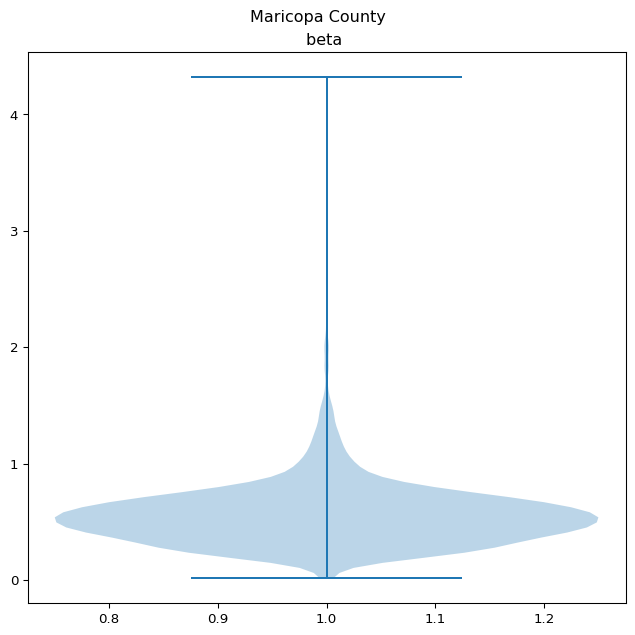

In [2]:
sdh_df = pd.DataFrame({k: list(v) for k, v in data.items()})
lat_lon_df = pd.DataFrame(sdh_df["centroid"].to_list(), columns=['Lon', 'Lat'])

sdh_df['gamma'] = 0 
sdh_df['gamma 0'] = 0.1000022

sdh_df['count'] = 1

sdh_df['x1'] = 0
sdh_df['x2'] = 0
sdh_df["h1"] = 0
sdh_df["h2"] = 0

sdh_df['beta'] = 0
sdh_df['alpha 0'] = 0.5
sdh_df["alpha 1"] = 0.4125
sdh_df["alpha 2"] = 0.5875

for i in range(len(sdh_df)):
    
    # Alpha values used to control beta
    a0 = sdh_df['alpha 0'][i]
    a1 = sdh_df['alpha 1'][i]
    a2 = sdh_df['alpha 2'][i]

    # Social Determinate of Health (SDH) values for beta
    x1 = sdh_df["average_household_size"][i]
    x2= sdh_df["median_age"][i]
    
    # Social Determinate of Health (SDH) values for gamma
    h1 = sdh_df["median_income"][i]
    h2 = sdh_df["tract_gini_index"][i]

    # Scaling function used to calculate beta and gamma 
    scale_x1 = (x1 - sdh_df["average_household_size"].mean()) / sdh_df["average_household_size"].std()
    scale_x2 = (x2 - sdh_df["median_age"].mean()) / sdh_df["median_age"].std()
    scale_h1 = (h1 - sdh_df["median_income"].mean()) / sdh_df["median_income"].std()
    scale_h2 = (h2 - sdh_df["tract_gini_index"].mean()) / sdh_df["tract_gini_index"].std()
    

    # Calculate gamma based on Alpha values used to control gamma
    g0 = sdh_df["gamma 0"][i]
  
    # Calculate the value of beta and gramma for each nodes
    beta = a0 * np.exp((( a1 * scale_x2) + (a2 * scale_x1)))
    gamma = g0 * (np.exp(-(scale_h1 + scale_h2)) / (1 + np.exp(-(scale_h1 + scale_h2))))

    # Saved the calculate value of beta and gamma in its respected node index
    sdh_df.loc[i, ['beta', 'gamma', 'x1', 'x2', 'h1', 'h2']] = [beta, gamma, scale_x1, scale_x2, scale_h1, scale_h2]

fig = plt.figure(figsize=(6.5,6.5), dpi=96, layout="constrained")

fig.suptitle('Maricopa County')

plt.violinplot(sdh_df['beta'])

plt.title('beta ')

plt.show()

In [3]:
sdh_df.head()

,labels,population,centroid,median_age,pop_by_age,median_income,total_income,average_household_size,pop_density_km2,tract_gini_index,...,gamma 0,count,x1,x2,h1,h2,beta,alpha 0,alpha 1,alpha 2
0,040130101011,1791,"[-111.770772219983, 33.7692433720249]",50.5,"[358, 110, 671, 374, 194, 84]",99219,90125800,2.33,99.301764,0.4423,...,0.100002,1,-0.576256,0.849774,0.799062,0.584471,0.506027,0.5,0.4125,0.5875
1,040130101012,2007,"[-111.720000642927, 33.741096326025]",63.9,"[162, 0, 423, 460, 559, 403]",127614,155213500,2.15,68.730308,0.4423,...,0.100002,1,-0.807494,1.889649,1.584744,0.584471,0.678365,0.5,0.4125,0.5875
2,040130101013,1264,"[-111.666997365524, 33.7239868229889]",70.8,"[0, 22, 0, 249, 655, 338]",80742,73694600,1.83,183.139061,0.4423,...,0.100002,1,-1.218585,2.425106,0.287808,0.584471,0.664507,0.5,0.4125,0.5875
3,040130101021,1139,"[-111.490977560506, 33.715337047738]",58.9,"[58, 52, 361, 362, 258, 48]",105987,89511200,2.04,0.474269,0.5439,...,0.100002,1,-0.948807,1.501636,0.986330,2.213862,0.531982,0.5,0.4125,0.5875
4,040130101022,1487,"[-111.850574119318, 33.8260427149521]",62.8,"[110, 82, 202, 500, 452, 141]",128523,128439900,2.20,125.178297,0.5439,...,0.100002,1,-0.743261,1.804286,1.609896,2.213862,0.680080,0.5,0.4125,0.5875


In [15]:
test = sdh_df.groupby(['population', 'pop_density_km2' ]).count()['count'].reset_index()
test = pd.DataFrame(test)

In [16]:
print(test.max())

population          9708.000000
pop_density_km2    14554.819527
count                  5.000000
dtype: float64


In [17]:
print(test)

      population  pop_density_km2  count
0              0         0.000000      5
1             13         3.316164      1
2             15         0.135440      1
3             25         0.274586      1
4             28        20.470453      1
...          ...              ...    ...
2496        7788      2302.198273      1
2497        7808       458.080484      1
2498        7929       378.078734      1
2499        8898       263.538066      1
2500        9708       614.211773      1

[2501 rows x 3 columns]


# Creates the IPM dataframe

In [52]:
header_names = ['ticks', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']

df = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
df['I & H->R'] = df['I->R'] + df['H->R']

plot_df = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
plot_df['I & H->R'] = plot_df['I->R'] + plot_df['H->R']

df = df.groupby(['tracts'], as_index=False).sum().drop(labels = 'ticks', axis = 'columns').sort_index()
plot_df = plot_df.groupby(['ticks'], as_index=False).sum().drop(labels = 'tracts', axis = 'columns').sort_index()


# Combines all the dataframe to create a geopandas dataframe

In [53]:
data = [df, sdh_df, lat_lon_df, maricopa]
geo_df = pd.concat(data, axis =1)
gpd_df = gpd.GeoDataFrame(geo_df)

gpd_df.to_csv(dir + '/utility/gpd.csv')

### Plotting result

<Figure size 1666.25x937.5 with 0 Axes>

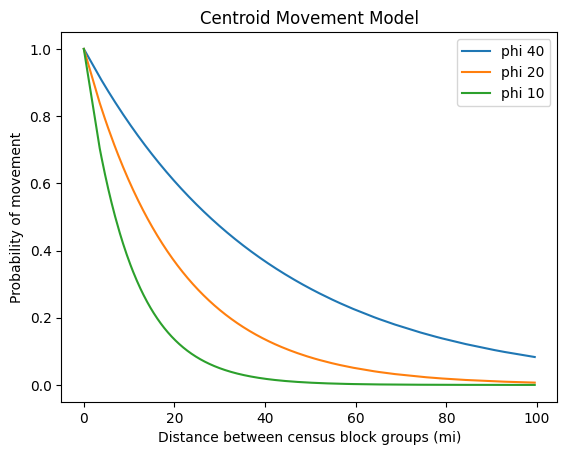

In [12]:
fig = plt.figure(figsize=(13.33,7.5), dpi=125)

fig.suptitle('Centroid Movement Model')
cgb.plot(x='distance',
        ylabel = 'Probability of movement', 
        xlabel = "Distance between census block groups (mi)",
        title = 'Centroid Movement Model')
plt.show()

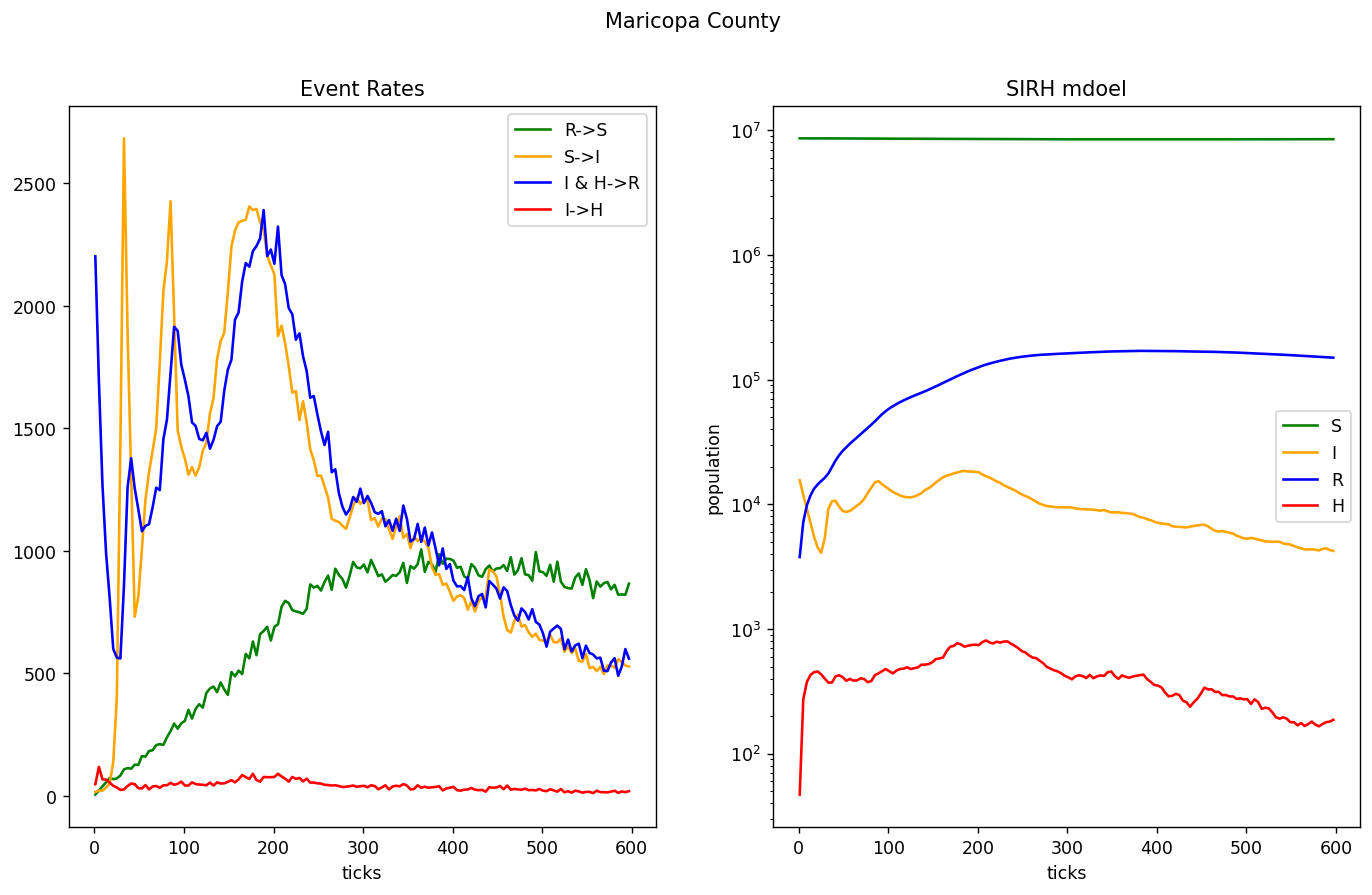

In [5]:
# Get current axis
plot_df.groupby(['ticks']).sum()
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13.33,7.5), dpi=125)

fig.suptitle('Maricopa County')
sirh = ['S', 'I', 'R', 'H']
sirh_name = ['Susceptible', 'Infected', 'Recovered', 'hospitalized']
event_rate = ['R->S', 'S->I', 'I & H->R', 'I->H' ]
color = ['green', 'orange', 'blue', 'red']

Events = plot_df[['ticks', 'S->I', 'I->R', 'I->H','H->R', 'R->S', 'I & H->R']]
sirh_compartment = plot_df[['ticks', 'S', 'I', 'R', 'H']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['ticks'] // 2, as_index=False).sum()
Events = Events.groupby(Events['ticks'] // 2, as_index=False).sum()

# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            x='ticks',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[1],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            x='ticks',
            y=event_rate[i],
            color=color[i], 
            ax=axes[0],
            title = 'Event Rates')    
# show the plot
plt.savefig(dir+'/plots/SIRH_model.png', bbox_inches='tight')
plt.show()

In [57]:
Events = Events.groupby(Events['days'] // 2, as_index=False).sum()
Events.head(-1)

,days,S->I,I->R,I->H,H->R,R->S,I & H->R
0,1,16,2202,47,0,5,2202
1,5,21,1679,118,12,21,1691
2,9,21,1238,67,28,39,1266
3,13,34,949,66,42,55,991
4,17,50,765,54,43,73,808
...,...,...,...,...,...,...,...
144,577,532,525,17,19,843,544
145,581,523,539,21,23,861,562
146,585,558,479,12,11,821,490
147,589,546,516,18,12,822,528


In [58]:
sirh_compartment.head(-1)

,days,S,I,R,H
0,1,8638193,15597,3783,47
1,5,8638193,11919,7235,273
2,9,8638214,9191,9839,376
3,13,8638267,7135,11790,428
4,17,8638312,5510,13347,451
...,...,...,...,...,...
144,577,8499882,4330,153237,171
145,581,8500537,4274,152643,166
146,585,8501101,4394,151952,173
147,589,8501632,4440,151369,179


NameError: name 'maricopa' is not defined

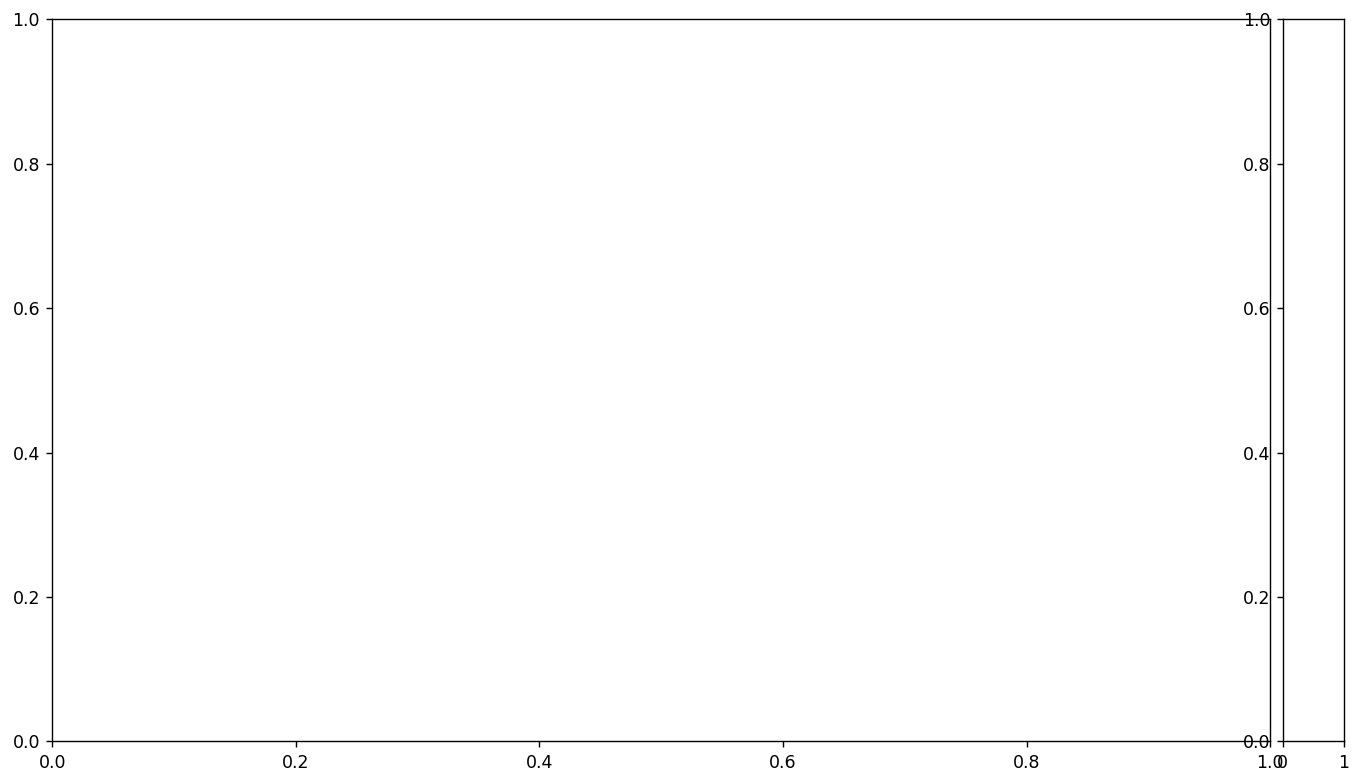

In [14]:
value = 'medain_income'

fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=125)
# add .shp mapfile to axes

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

maricopa.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

gpd_df.plot(
    ax = ax, 
    edgecolor = 'black', 
    column = value, 
    legend = True, 
    cmap='hot',
    vmin = geo_df[value].min(), 
    vmax = geo_df[value].max(),
    linewidth = 0.01,
    cax=cax,
    legend_kwds={"label": 'I compartment', "orientation": "vertical"},
    )
png = str(['I'])
plt.savefig(dir+'/plots/' + png + '.png', bbox_inches='tight')
plt.show()


In [15]:
sdh_df.head()

,labels,population,centroid,median_age,pop_by_age,median_income,total_income,average_household_size,pop_density_km2,tract_gini_index,gamma,gamma 0,beta,alpha 0,alpha 1,alpha 2
0,040130101011,1791,"[-111.770772219983, 33.7692433720249]",50.5,"[358, 110, 671, 374, 194, 84]",99219,90125800,2.33,99.301764,0.4423,0.020045,0.100002,0.021608,0.05,0.4125,0.5875
1,040130101012,2007,"[-111.720000642927, 33.741096326025]",63.9,"[162, 0, 423, 460, 559, 403]",127614,155213500,2.15,68.730308,0.4423,0.010255,0.100002,0.018727,0.05,0.4125,0.5875
2,040130101013,1264,"[-111.666997365524, 33.7239868229889]",70.8,"[0, 22, 0, 249, 655, 338]",80742,73694600,1.83,183.139061,0.4423,0.029479,0.100002,0.015112,0.05,0.4125,0.5875
3,040130101021,1139,"[-111.490977560506, 33.715337047738]",58.9,"[58, 52, 361, 362, 258, 48]",105987,89511200,2.04,0.474269,0.5439,0.003916,0.100002,0.016960,0.05,0.4125,0.5875
4,040130101022,1487,"[-111.850574119318, 33.8260427149521]",62.8,"[110, 82, 202, 500, 452, 141]",128523,128439900,2.20,125.178297,0.5439,0.002138,0.100002,0.019708,0.05,0.4125,0.5875


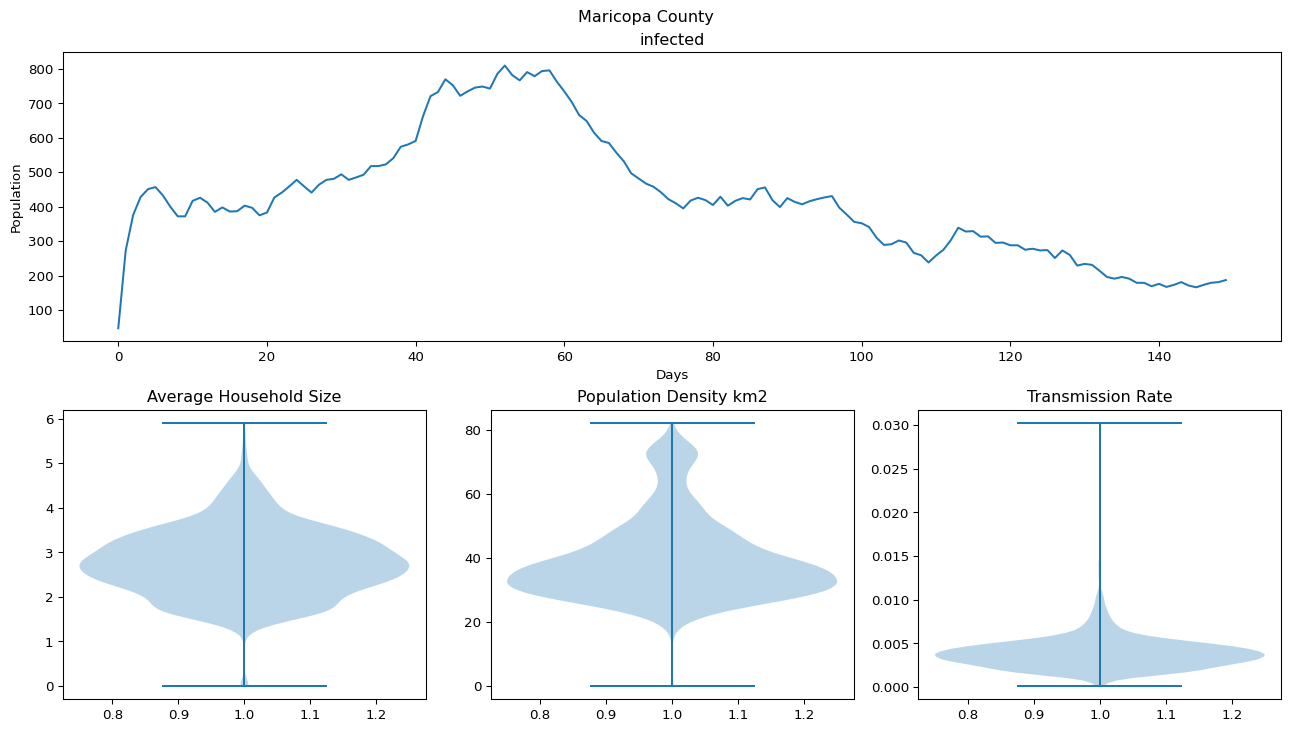

In [43]:
fig = plt.figure(figsize=(13.33,7.5), dpi=96, layout="constrained")

spec = fig.add_gridspec(2, 3)
fig.suptitle('Maricopa County')

ax0 = fig.add_subplot(spec[0, :])
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])
ax12 = fig.add_subplot(spec[1, 2])

ax0.plot(sirh_compartment['H'])
ax0.set_ylabel('Population')
ax0.set_xlabel('Days')
ax0.set_title('infected')

ax10.violinplot(sdh_df['average_household_size'])
ax10.set_title('Average Household Size')

ax11.violinplot(sdh_df['median_age'])
ax11.set_title('Population Density km2')

ax12.violinplot(sdh_df['beta'])

ax12.set_title('Transmission Rate')

#plt.savefig(dir+'/plots/beta_gamma.png', bbox_inches='tight')
plt.show()


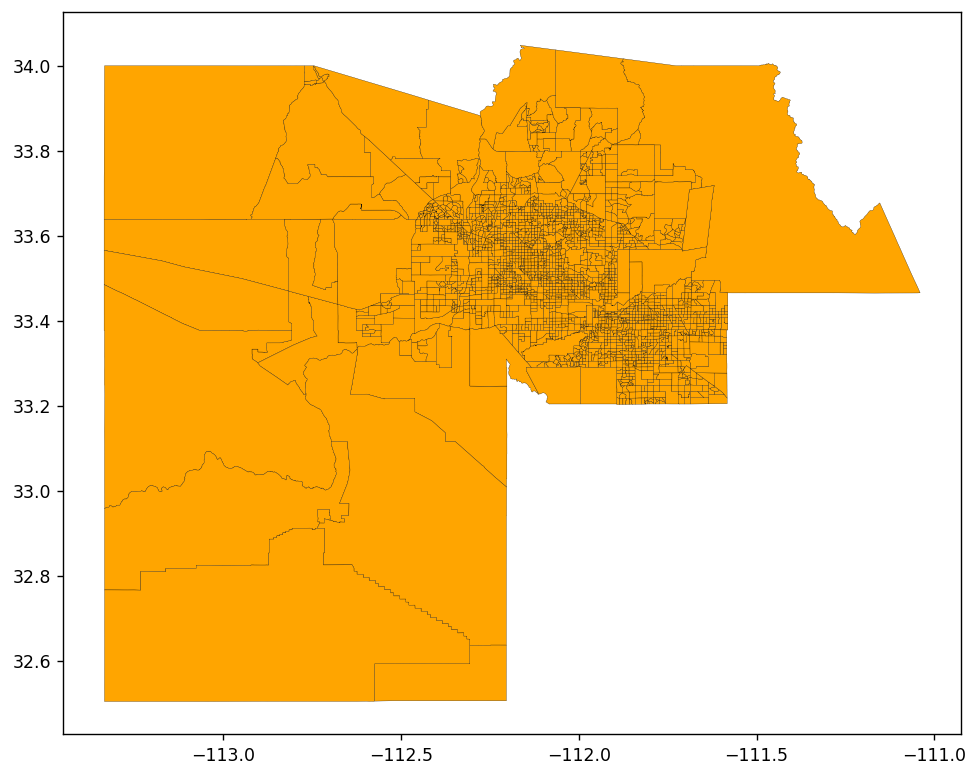

In [34]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=125)
maricopa.plot(ax = ax, edgecolor='black',color='orange', linewidth = 0.15)
plt.show()

In [78]:
dist = pd.read_csv(dir + '/phi_10.csv')

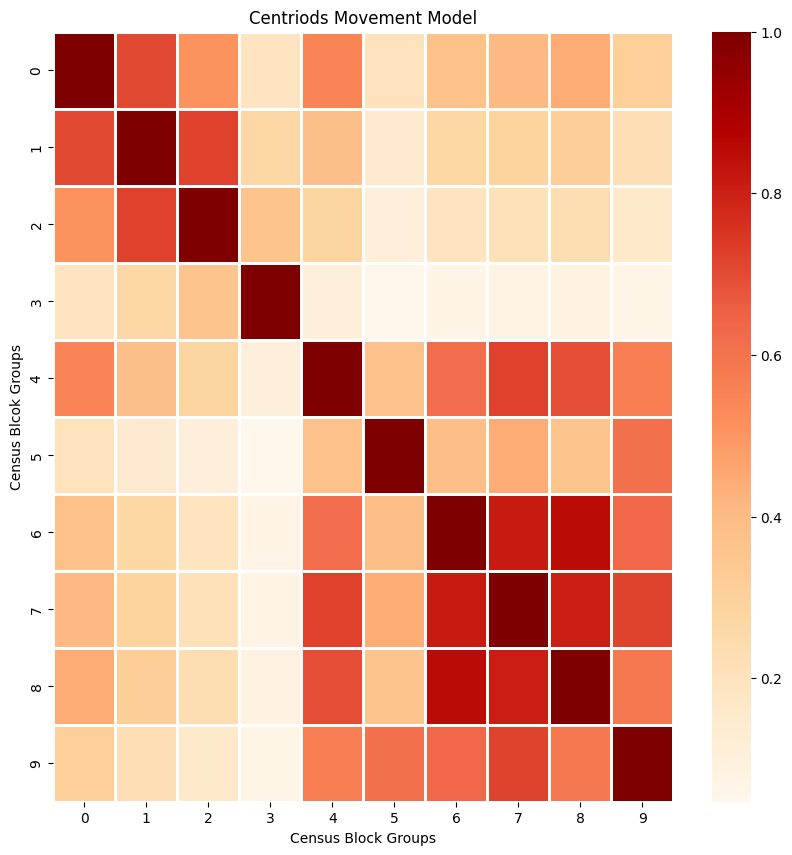

In [79]:
plt.figure(figsize=(10,10))
sns.heatmap(
    dist,
    cmap='OrRd',
    linewidth=1,
)
plt.ylabel('Census Blcok Groups')
plt.xlabel('Census Block Groups')
plt.title('Centriods Movement Model')
plt.show()